In [1]:
import SimFunctions
import SimRNG 
import SimClasses
import numpy as np
import pandas
import matplotlib.pyplot as plt
import scipy.stats as stats


Bad key "lines.markerfacecolor" on line 11 in
C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution

Bad key "lines.markeredgecolor" on line 12 in
C:\Users\Administrator\AppData\Roaming\Python\Python35\site-packages\matplotlib\mpl-data\stylelib\classic.mplstyle.
You probably need to get an updated matplotlibrc file from
http://github.com/matplotlib/matplotlib/blob/master/matplotlibrc.template
or from the matplotlib source distribution


In [56]:

#ZSimRNG = SimRNG.InitializeRNSeed()
Queue = SimClasses.FIFOQueue()
Wait = SimClasses.DTStat()
Server = SimClasses.Resource()
Calendar = SimClasses.EventCalendar()

TheCTStats = []
TheDTStats = []
TheQueues = []
TheResources = []

TheDTStats.append(Wait)
TheQueues.append(Queue)
TheResources.append(Server)

Server.SetUnits (1) 

In [57]:
order_threshold = 2.0
order_up_to = 5.0 
delivery_delay = 20 # in minutes
SIM_RUN = 1000  #number of simulation runs
initial_bikes = 15
operation_cost = 2 # USD per bike for operation
oil_gas = 3 # USD per 1 refillment
service_fee = 3 # USD per bike per ride
PENALTY = 3 # USD for cost of loss of business oportunity
loss_profit = 0.1 # USD per bike per minute for loss of business opportunity
RunLength = 180.0

In [58]:
def Arrival(_lambda ,requirement):
    global num_bikes, revenue, penalty, Loss_profit
    interarrival = SimRNG.Expon(1./_lambda,1)
    SimFunctions.Schedule(Calendar,requirement,interarrival)
    Loss_profit += loss_profit * num_bikes * interarrival
    if requirement == 'Rent a bike':
        if num_bikes > 0:
            num_bikes -= 1
            revenue += service_fee
        else:
            penalty += PENALTY
            
    else:
        num_bikes += 1
    

In [59]:
def rebalancing(quantity):
    global num_bikes, num_ordered, revenue , cost, Loss_profit
    
    num_ordered = quantity
    cost += (num_ordered * operation_cost) + oil_gas 

    num_bikes += num_ordered
#    print (" Fill bikes up to ={}".format(num_bikes))
    num_ordered = 0

In [60]:
def citibike_run(_lambda ,requirement, order_up_to, order_threshold):
    global num_bikes, quantity, num_ordered, revenue , cost, penalty, Loss_profit
    num_ordered = 0.0
    quantity = 0.0
    #while True:
        
    Arrival(_lambda ,requirement)
        
    get_bikes.append(num_bikes)
    if num_bikes <= order_threshold and num_ordered == 0:
        quantity = order_up_to - num_bikes
        SimFunctions.Schedule(Calendar,"rebalancing",delivery_delay)

In [61]:
def observe():

    while True:

        obs_time.append(SimClasses.Clock)
        obs_bikes.append(num_bikes)
        obs_balance.append(revenue - cost - penalty - Loss_profit)

In [62]:
avg_bikes = []
avg_balance = []
get_balance = []

In [66]:
for i in range(SIM_RUN):
    np.random.seed(i)
    num_bikes = initial_bikes
    revenue = 0
    cost = 0
    penalty = 0
    Loss_profit = 0
    obs_time = []
    obs_bikes = []
    obs_balance = []
    get_bikes = []

    SimFunctions.SimFunctionsInit(Calendar,TheQueues,TheCTStats,TheDTStats,TheResources)
    citibike_run(1.572 ,'Rent a bike', order_up_to, order_threshold)
    citibike_run(1.183 ,'Return a bike', order_up_to, order_threshold)
    SimFunctions.Schedule(Calendar,"EndSimulation",RunLength)
    
    NextEvent = Calendar.Remove()
    SimClasses.Clock = NextEvent.EventTime
    if NextEvent.EventType == 'Rent a bike':
        citibike_run(1.572 ,'Rent a bike', order_up_to, order_threshold)
    elif NextEvent.EventType == 'Return a bike':
        citibike_run(1.183 ,'Return a bike', order_up_to, order_threshold)
    else:
        rebalancing(quantity)

    while NextEvent.EventType != "EndSimulation":
        NextEvent = Calendar.Remove()
        SimClasses.Clock = NextEvent.EventTime
        if NextEvent.EventType == 'Rent a bike':
            citibike_run(1.572 ,'Rent a bike', order_up_to, order_threshold)
        elif NextEvent.EventType == 'Return a bike':
            citibike_run(1.183 ,'Return a bike', order_up_to, order_threshold)
        else:
            rebalancing(quantity)

    avg_bikes.append(np.mean(get_bikes))
    avg_balance.append(revenue - cost - penalty - Loss_profit)


No handles with labels found to put in legend.


The average number of available bikes during the interval =  7.5889929813365375


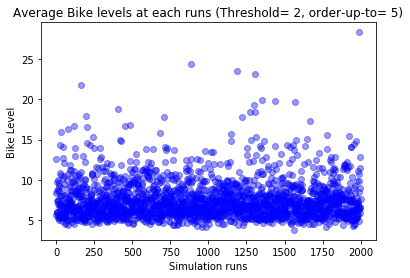

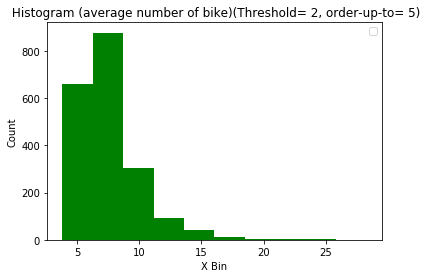

In [67]:
if SIM_RUN > 1:    
    print ("The average number of available bikes during the interval = ", np.mean(avg_bikes))
    plt.figure()
    plt.scatter(range(len(avg_bikes)), avg_bikes, c='b', alpha=0.4)    
    plt.xlabel('Simulation runs')
    plt.ylabel('Bike Level')
    plt.title('Average Bike levels at each runs (Threshold= {:.0f}, order-up-to= {:.0f})'.format(order_threshold, order_up_to))
    plt.savefig('Average bike level.png')
    
    plt.figure()
    plt.hist( avg_bikes, color='g')
    plt.xlabel('X Bin')
    plt.ylabel('Count')
    plt.title(' Histogram (average number of bike)(Threshold= {:.0f}, order-up-to= {:.0f})'.format(order_threshold, order_up_to))
    plt.legend(loc='best')
    plt.savefig('Histogram Average bike level.png')

In [20]:
avg_bikes

[10.726744186046512,
 6.527272727272727,
 5.357723577235772,
 7.438223938223938,
 6.344262295081967,
 6.16044776119403,
 6.734151329243354,
 4.294,
 9.350293542074365,
 9.765350877192983]

In [21]:
avg_balance

[105.30687824825122,
 353.06448940748254,
 -42.740283269088735,
 242.62380204743067,
 113.55265138153311,
 -22.80064541006149,
 72.40974540302005,
 -122.54321098999347,
 197.35702484864834,
 159.02567588817112]